# Natural Language Processing with RNNs - Toxic Comment Classification

Outline:

1. Download and explore the data
2. Prepare the data for training
3. Build a recurrent neural network
4. Train & evaluate the model
5. Make predictions & submit to Kaggle

## 1.Download & Explore Data

Outline:
1. Download the data from Kaggle
2. Load data into Pandas dataframes
3. Explore the dataset

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 99% 52.0M/52.6M [00:04<00:00, 17.0MB/s]
100% 52.6M/52.6M [00:04<00:00, 11.3MB/s]


In [6]:
!unzip jigsaw-toxic-comment-classification-challenge.zip -d data

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: data/sample_submission.csv.zip  
  inflating: data/test.csv.zip       
  inflating: data/test_labels.csv.zip  
  inflating: data/train.csv.zip      


In [7]:
import pandas as pd

raw_df = pd.read_csv('data/train.csv.zip')
test_df = pd.read_csv('data/test.csv.zip')
sub_df = pd.read_csv('data/sample_submission.csv.zip')


In [8]:
raw_df.shape, test_df.shape, sub_df.shape

((159571, 8), (153164, 2), (153164, 7))

In [9]:
raw_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
test_df.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
sub_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [12]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [13]:
for col in target_cols:
    print(raw_df[col].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [14]:
for col in target_cols:
    print(raw_df[col].value_counts(normalize=True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


## 2.Prepare the Dataset for Training

Outline:
- Create a vocabulary using TorchText
- Create training & validation sets
- Create PyTorch dataloaders

### Create a Vocabulary

In [15]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [16]:
sample_comment = raw_df.comment_text.values[0]
sample_comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [17]:
sample_comment_tokens = tokenizer(sample_comment)
sample_comment_tokens[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica']

In [18]:
from torchtext.vocab import build_vocab_from_iterator

### the column "comment_text" is a series, and it will return comments one by one
### but our requirement is to get sets of tokens one by one, so we call .map
comment_tokens = raw_df.comment_text.map(tokenizer)

VOCAB_SIZE = 1500


unk_token = '<unk>'   #represent words not present in the vocabulary
pad_token = '<pad>'   # for rnn we need input sequences to be of equal lenghth, 
                      # pad token will pad the shorter sentences and 
                      # clip the longer sentences


vocab = build_vocab_from_iterator(comment_tokens, 
                                  specials = [unk_token,pad_token],
                                  max_tokens = VOCAB_SIZE)


In [19]:
vocab['this']

# The word 'this' has the position 18. The 'vocab' assigns a number to every word. 
# This is how we convert our tokenised comments into numbers

18

In [20]:
vocab[unk_token]

0

In [21]:
### This will assign value 0 to any token not present in the vocab as 
### we have assigned the vocab size of 1500 only, there is a possibility of finding new word
vocab.set_default_index(vocab[unk_token])

In [22]:
sample_indices = vocab.lookup_indices(sample_comment_tokens)
sample_indices[:10]
## These numbers are tokens converted into numbers which denotes the position of the tokens in the sentence

[667, 85, 3, 140, 142, 185, 39, 663, 0, 0]

In [23]:
sample_comment_recovered = vocab.lookup_tokens(sample_indices)
sample_comment_recovered[:10]
## note the last 2 words, unknown words not present in our vocabulary

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 '<unk>',
 '<unk>']

### Create Training & Validation Sets

- Define a custom Pytorch Dataset
- Pass raw data into the dataset
- Split the PyTorch Dataset

##### Define custom Pytorch Dataset

In [24]:
from torch.utils.data import Dataset

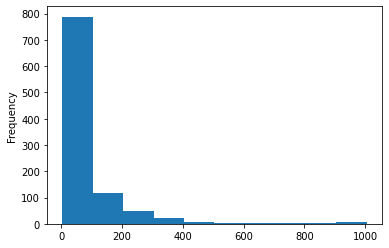

In [25]:
### defining max_length 

raw_df.comment_text.sample(1000).map(tokenizer).map(len).plot(kind='hist')

### EXAMPLE HOW PAD TOKENS WORK ?


In [26]:
MAX_LENGTH = 4

In [27]:
def pad_tokens(tokens): 
  if (len(tokens) >= MAX_LENGTH):
    return tokens[: MAX_LENGTH]
  else:
    return tokens + [pad_token] * (MAX_LENGTH - len(tokens))

In [28]:
pad_tokens(tokenizer('I love this'))

['i', 'love', 'this', '<pad>']

In [29]:
pad_tokens(tokenizer('This is great, is it not ?'))

['this', 'is', 'great', ',']

--------------

In [30]:
MAX_LENGTH = 150

In [31]:
def pad_tokens(tokens): 
  if (len(tokens) >= MAX_LENGTH):
    return tokens[: MAX_LENGTH]
  else:
    return tokens + [pad_token] * (MAX_LENGTH - len(tokens))

3 functions in the class

In [32]:
import torch

In [33]:
class JigsawDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.df = df
        self.is_test = is_test

    def __getitem__(self, index):
        comment_text = self.df.comment_text.values[index]
        comment_tokens = pad_tokens(tokenizer(comment_text))
        input = torch.tensor(vocab.lookup_indices(comment_tokens))
        if self.is_test:
            target = torch.tensor([0,0,0,0,0,0]).float()
        else:
            target = torch.tensor(self.df[target_cols].values[index]).float()
        return input, target

    def __len__(self):
        return len(self.df)

In [34]:
raw_ds = JigsawDataset(raw_df)


In [35]:
raw_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [36]:
raw_ds[0]

(tensor([ 667,   85,    3,  140,  142,  185,   39,  663,    0,    0, 1287,   96,
          329,   27,   57,    0,    9,   31,    0,    4,   61,    0,   21,   71,
            0,  158,    6,    0,   45,  130, 1167,    0,    0,    2,    8,   55,
           70,    9,   31,  253,    3,  369,   41,    3,   50,   38,  155,    6,
            9,   81,    0,   99,    2,    0,    2,    0,    2,    0,    2, 1122,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [37]:
from torch.utils.data import random_split

VAL_FRAC = 0.25

train_ds, val_ds = random_split(raw_ds, [1-VAL_FRAC, VAL_FRAC])
len(raw_ds), len(train_ds), len(val_ds)

(159571, 119679, 39892)

In [38]:
test_ds = JigsawDataset(test_df, is_test=True)

In [39]:
test_df.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [40]:
test_ds[0]

(tensor([   0,  636,    0,  649,   12,   69,    0,   93,   10,    9,  169,  359,
           23,    0,   89,   30,   10,    8,    0,   10, 1488,    0,    2,    2,
            2,    6,   68,  636,    0,    0,    0,  690,    0,    8,  105,   10,
            5,    0,   39,  419,   10,  699,    0,   46,    2,    0,  649,   12,
           47,    0,   15,    0,  668,  439,    2,  443,    0,   13,  332,   21,
          167,    2,    8,    0,   12,  251,    0,   62,    0,   59,   34,   11,
            0,  171,    2,    2,    2,    0,  690,    0,  105,  226,  160,  490,
           95,    2,    4,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

### Create PyTorch Dataloaders

In [41]:
from torch.utils.data import DataLoader

In [42]:
BATCH_SIZE = 256

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)

In [43]:
for batch in train_dl:
    b_inputs, b_targets = batch
    print('b_input.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)

    break

b_input.shape torch.Size([256, 150])
b_targets.shape torch.Size([256, 6])


## Build a Recurrent Neural Network

Outline:
1. Understand how recurrent neural networks work
2. Create a recurrent neural network
3. Pass some through the network

1. Understand how recurrent neural networks work

In [44]:
import torch.nn as nn
import torch.functional as F

In [45]:
vocab[pad_token]

1

In [46]:
### Create an "embedding" layer 
### assigning size 256, each word will be a vector of size 256
### 1 is the index of pad token
emb_layer = nn.Embedding(VOCAB_SIZE, 256, 1)

In [47]:
### Creating an rnn layer 
### 256 > as each of the word vector is of size 256
### 
rnn_layer = nn.RNN(256, 128, 1, batch_first=True)

In [48]:
for batch in train_dl:
    b_inputs, b_targets = batch
    print('b_input.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)

    emb_out = emb_layer(b_inputs)
    print('emb_out.shape', emb_out.shape)

# hn for returning the hidden layer output
    rnn_out, hn = rnn_layer(emb_out)
    print('rnn_out.shape', rnn_out.shape)
    print('hn.shape', hn.shape)

    break

b_input.shape torch.Size([256, 150])
b_targets.shape torch.Size([256, 6])
emb_out.shape torch.Size([256, 150, 256])
rnn_out.shape torch.Size([256, 150, 128])
hn.shape torch.Size([1, 256, 128])


###### *What happens in the above step ?*
Input has shape (256, 150) which means there are 256 rows in the batch and each row contains a vector of size 150 which is simply the indices of the token present in the comment. 

##### When we pass the vector to the embedding layer, we get the output (256, 150, 256), 256 rows and a matrix of size 150x256. The embedding layer has taken each of the indices of the tokens present in the comment text and converted the indices into word vectors, each word with a vector of size 256. 

From the embedding layer, we got 150 vectors each of size 256, when we pass those 256 vectors into the RNN one-by-one, each of them resulted in an output of size 128. And output from the final rnn for the hidden state is also achieved. 

### Define our model 

In [49]:
!pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 16.9 MB/s eta 0:00:00


In [50]:
import pytorch_lightning as pl
import torch.nn.functional as F

In [56]:
import numpy as np

In [53]:
class JigsawModel(pl.LightningModule):
    def __init__(self):
      super().__init__()
      self.emb = nn.Embedding(VOCAB_SIZE, 256, 1)
      self.lstm = nn.LSTM(256, 128, 1, batch_first=True)
      self.linear = nn.Linear(128, 6)
      self.learning_rate = 0.001

    def forward(self, x):
      out = self.emb(x)
      out, hn = self.lstm(out)
      out = F.relu(out[:,-1,:])
      out = self.linear(out)
      return out

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        loss = F.binary_cross_entropy(probs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        loss = F.binary_cross_entropy(probs, targets)
        return loss.item()

    def validation_epoch_end(self, validation_step_outputs):
        loss = np.mean(validation_step_outputs)
        print("Epoch #{}; Loss: {:4f} ".format(self.current_epoch, loss)) 

    def predict_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        return probs       

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      


Any pytorch module has 2 functions in it : "init" and "forward" functions.

###### we will be using an advanced form of RNN called LSTM 

In [54]:
model = JigsawModel()

In [55]:
for batch in train_dl:
    b_inputs, b_targets = batch
    print('b_input.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)

    outputs = model(b_inputs)
    print('outputs.shape', outputs.shape)

    probs = torch.sigmoid(outputs)
    loss = F.binary_cross_entropy(probs, b_targets)
    print('Loss', loss)
    break

b_input.shape torch.Size([256, 150])
b_targets.shape torch.Size([256, 6])
outputs.shape torch.Size([256, 6])
Loss tensor(0.7063, grad_fn=<BinaryCrossEntropyBackward0>)


## Train and Evaluate the Model

In [57]:
trainer = pl.Trainer(max_epochs=3, accelerator='gpu', auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [58]:
trainer.tune(model, train_dl)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.006918309709189364
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_725cfbfe-e808-455a-818c-119e5065b774.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_725cfbfe-e808-455a-818c-119e5065b774.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f2dda24c7c0>}

In [59]:
model.learning_rate

0.006918309709189364

The model tries to find the learning rate in the above step, and next it tries to fit the model. 

*What happens in the step ?*
The trainer picks up the training data loader, it starts to get batches from the training data loader one by one. It gets the first batch from the training dataloader  then it calls the method "training_step" (in the above function) from the batch which gets the inputs and targets from the batch, then we take the inputs and pass it into the model and get some outputs & apply the sigmoid function to it to get probabilities. (we get 6 outputs for every row of data as we are predicting 6 classes) Then it calculates the loss, using which we calculate the gradients for all the parameters present inside the model. And then using the gradient descent optimisation technique, we tweek all the parameters to make the model slightly better by making better predictions and minimising the loss, which is done batch after batch for the entire training set. 


###### Once all the training batches are complete, it goes through the validation step, here it simply collects all the losses and at the end of validation epoch it computes the mean of the loss. 

In [60]:
trainer.fit(model, train_dl, val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 384 K 
1 | lstm   | LSTM      | 197 K 
2 | linear | Linear    | 774   
-------------------------------------
582 K     Trainable params
0         Non-trainable params
582 K     Total params
2.330     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch #0; Loss: 0.707327 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch #0; Loss: 0.067591 


Validation: 0it [00:00, ?it/s]

Epoch #1; Loss: 0.065042 


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch #2; Loss: 0.064537 


## Make Predictions & Submit

In [61]:
test_df.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [62]:
for batch in test_dl:
    b_inputs, b_targets = batch
    print('b_inputs.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)
    break

b_inputs.shape torch.Size([512, 150])
b_targets.shape torch.Size([512, 6])


In [64]:
test_preds = trainer.predict(model, test_dl)
# test_preds

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 468it [00:00, ?it/s]

In [65]:
test_preds = torch.cat(test_preds)
# test_preds

In [66]:
test_preds.shape

torch.Size([153164, 6])

In [67]:
test_preds.shape

torch.Size([153164, 6])

In [68]:
test_probs = torch.sigmoid(test_preds)

In [69]:
sub_df[target_cols] = test_probs.detach().cpu().numpy()
sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.727633,0.576325,0.716452,0.503650,0.690897,0.544183
1,0000247867823ef7,0.502055,0.500011,0.500395,0.500025,0.500310,0.500122
2,00013b17ad220c46,0.501194,0.500006,0.500262,0.500016,0.500215,0.500103
3,00017563c3f7919a,0.502238,0.500010,0.500361,0.500021,0.500309,0.500114
4,00017695ad8997eb,0.503110,0.500019,0.500482,0.500068,0.500404,0.500182
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.502230,0.500012,0.500432,0.500027,0.500342,0.500135
153160,fffd7a9a6eb32c16,0.504605,0.500032,0.500870,0.500058,0.500787,0.500269
153161,fffda9e8d6fafa9e,0.503394,0.500020,0.500619,0.500034,0.500555,0.500191
153162,fffe8f1340a79fc2,0.502221,0.500012,0.500440,0.500028,0.500350,0.500136


In [70]:
sub_df.to_csv('submission.csv', index=None)